In [36]:
# import opendatasets as od

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import json
import os
import re
import ast
import math
from collections import Counter

from implicit.nearest_neighbours import BM25Recommender
from implicit.als import AlternatingLeastSquares
# from implicit.gpu.als import AlternatingLeastSquares

from surprise.model_selection import train_test_split
from surprise import accuracy, Dataset, Reader
from surprise import SVD

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds


from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



# Movie 

In [1157]:
rating = pd.read_csv("datasets/movie dataset/ratings.csv")
rating

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


In [1186]:
movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)
movies_metadata = movies_metadata[~movies_metadata.id.str.contains("-")]
movies_metadata=movies_metadata[~movies_metadata['title'].isnull()]
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata.columns

<ipython-input-1186-a78f9aca8e1b>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [1187]:
links = pd.read_csv("datasets/movie dataset/links.csv", low_memory=True)
links.columns

Index(['movieId', 'imdbId', 'tmdbId'], dtype='object')

In [1188]:
movies_metadata = movies_metadata[['id','title', 'genres','release_date','overview', 'adult','vote_average', 'vote_count']]
movies_metadata

,id,title,genres,release_date,overview,adult,vote_average,vote_count
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",1995-10-30,"Led by Woody, Andy's toys live happily in his ...",False,7.7,5415.0
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",1995-12-15,When siblings Judy and Peter discover an encha...,False,6.9,2413.0
2,15602,Grumpier Old Men,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",1995-12-22,A family wedding reignites the ancient feud be...,False,6.5,92.0
3,31357,Waiting to Exhale,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",1995-12-22,"Cheated on, mistreated and stepped on, the wom...",False,6.1,34.0
4,11862,Father of the Bride Part II,"[{'id': 35, 'name': 'Comedy'}]",1995-02-10,Just when George Banks has recovered from his ...,False,5.7,173.0
...,...,...,...,...,...,...,...,...
45461,439050,Subdue,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",NaN,Rising and falling between a man and woman.,False,4.0,1.0
45462,111109,Century of Birthing,"[{'id': 18, 'name': 'Drama'}]",2011-11-17,An artist struggles to finish his work while a...,False,9.0,3.0
45463,67758,Betrayal,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",2003-08-01,"When one of her hits goes wrong, a professiona...",False,3.8,6.0
45464,227506,Satan Triumphant,[],1917-10-21,"In a small town live two brothers, one a minis...",False,0.0,0.0


In [1190]:
movies = pd.merge(movies_metadata, links, how="left", left_on='id', right_on='tmdbId')[['movieId','id','title','genres','release_date','adult','overview','vote_average','vote_count']]

In [1191]:
movies['genres'].replace({"\'": "\""}, regex=True)
temp = pd.json_normalize((movies['genres'].replace({"\'": "\""}, regex=True)).apply(json.loads))

In [1192]:
# turn array of genre dicts into concat str
for column in temp.columns:
    temp[column] = temp[column].apply(lambda x: x['name'] if x is not None else "")
temp['genres'] = temp.agg('|'.join, axis=1)
temp['genres'] = temp['genres'].apply(lambda x: x.rstrip('|'))

In [1193]:
movies['genres'] = temp['genres']
movies = movies.set_index('movieId')
movies = movies[~movies.duplicated()]
del temp

In [1165]:
data = csr_matrix((rating.rating.values.astype('f8'),
                   (rating.userId.values,rating.movieId.values)
                  ))

In [1166]:
_, S, V = svds(data, k=150, return_singular_vectors='vh')

In [1167]:
movies[movies.title.str.contains('Inception',flags=2,na=False)]

,id,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,,
79132,27205,Inception,Action|Thriller|Science Fiction|Mystery|Adventure,2010-07-14,False,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0


In [271]:
movies[('Face/Off' == movies['title']) | ('The Rock' == movies['title'])]

,title,genres,release_date,overview,vote_average,vote_count
movieId,,,,,,
733,The Rock,Drama|Comedy|War,1996-06-06,A group of renegade marine commandos seizes a ...,6.9,1474.0
1573,Face/Off,Drama|Action|Thriller|Crime,1997-06-27,An antiterrorism agent goes under the knife to...,6.8,1612.0


In [1169]:
movies.loc[np.argsort(-V.T @ V[:, [79132]].sum(axis=1))[:10]]

,id,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,,
79132,27205,Inception,Action|Thriller|Science Fiction|Mystery|Adventure,2010-07-14,False,"Cobb, a skilled thief who commits corporate es...",8.1,14075.0
74458,11324,Shutter Island,Drama|Thriller|Mystery,2010-02-18,False,World War II soldier-turned-U.S. Marshal Teddy...,7.8,6559.0
58559,155,The Dark Knight,Drama|Action|Crime|Thriller,2008-07-16,False,Batman raises the stakes in his war on crime. ...,8.3,12269.0
109487,157336,Interstellar,Adventure|Drama|Science Fiction,2014-11-05,False,Interstellar chronicles the adventures of a gr...,8.1,11187.0
72998,19995,Avatar,Action|Adventure|Fantasy|Science Fiction,2009-12-10,False,"In the 22nd century, a paraplegic Marine is di...",7.2,12114.0
68157,16869,Inglourious Basterds,Drama|Action|Thriller|War,2009-08-18,False,"In Nazi-occupied France during World War II, a...",7.9,6598.0
91529,49026,The Dark Knight Rises,Action|Crime|Drama|Thriller,2012-07-16,False,Following the death of District Attorney Harve...,7.6,9263.0
2571,603,The Matrix,Action|Science Fiction,1999-03-30,False,"Set in the 22nd century, The Matrix tells the ...",7.9,9079.0
99114,68718,Django Unchained,Drama|Western,2012-12-25,False,"With the help of a German bounty hunter, a fre...",7.8,10297.0


# Making own dataset

In [ ]:
movielens = pd.read_csv('datasets/movielens/movies.csv')
movielens = movielens.set_index('movieId')

In [1195]:
new_movies = pd.merge(movies, movielens, how="inner", on='movieId')[['id','movieId','title_x', 'genres_x', 'genres_y', 'release_date', 'adult', 'overview', 'vote_average', 'vote_count']]
new_movies = new_movies.rename(columns={"title_x": "title"})

In [1196]:
new_movies.loc[(new_movies['genres_x'] == '') & (new_movies['genres_y'].isnull() == False),'genres_x'] =new_movies.loc[(new_movies['genres_x'] == '') & (new_movies['genres_y'].isnull() == False),'genres_y']

In [1197]:
new_movies.loc[(new_movies['genres_y'].str.contains("no genres listed")),'genres_x'] = np.nan
new_movies = new_movies[['id', 'movieId','title', 'genres_x','release_date','adult','overview', 'vote_average', 'vote_count']]
new_movies = new_movies.rename({'genres_x': 'genres'})

In [1202]:
def split_and_convert(genre_str):
    if pd.isna(genre_str):
        return []
    else:
        return genre_str.split('|')

new_movies['genres_x'] = new_movies['genres_x'].apply(split_and_convert)
new_movies

,id,movieId,title,genres_x,release_date,adult,overview,vote_average,vote_count
0,862,1,Toy Story,"[Animation, Comedy, Family]",1995-10-30,False,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0
1,8844,2,Jumanji,"[Adventure, Fantasy, Family]",1995-12-15,False,When siblings Judy and Peter discover an encha...,6.9,2413.0
2,15602,3,Grumpier Old Men,"[Romance, Comedy]",1995-12-22,False,A family wedding reignites the ancient feud be...,6.5,92.0
3,31357,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995-12-22,False,"Cheated on, mistreated and stepped on, the wom...",6.1,34.0
4,11862,5,Father of the Bride Part II,[Comedy],1995-02-10,False,Just when George Banks has recovered from his ...,5.7,173.0
...,...,...,...,...,...,...,...,...,...
43002,439050,176269,Subdue,"[Drama, Family]",NaN,False,Rising and falling between a man and woman.,4.0,1.0
43003,111109,176271,Century of Birthing,[Drama],2011-11-17,False,An artist struggles to finish his work while a...,9.0,3.0
43004,67758,176273,Betrayal,"[Action, Drama, Thriller]",2003-08-01,False,"When one of her hits goes wrong, a professiona...",3.8,6.0
43005,227506,176275,Satan Triumphant,[],1917-10-21,False,"In a small town live two brothers, one a minis...",0.0,0.0


In [1749]:
credits = pd.read_csv('datasets/movie dataset/credits.csv') 
keywords = pd.read_csv('datasets/movie dataset/keywords.csv')
movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)
movies_metadata = movies_metadata[~movies_metadata.id.str.contains("-")]
movies_metadata=movies_metadata[~movies_metadata['title'].isnull()]
movies_metadata['id'] = movies_metadata['id'].astype(int)
movies_metadata.columns
links = pd.read_csv('datasets/movie dataset/links.csv')
links = links[links['tmdbId'].notnull()]['tmdbId'].astype('int')

<ipython-input-1749-d12df6b2e388>:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  movies_metadata = pd.read_csv("datasets/movie dataset/movies_metadata.csv", low_memory=True)


In [1750]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies_metadata['id'] = movies_metadata['id'].astype('int')

In [1751]:
movies_metadata = movies_metadata.merge(credits, on='id')
movies_metadata = movies_metadata.merge(keywords, on='id')

In [1752]:
smd = movies_metadata[movies_metadata['id'].isin(links)]
smd.shape

(46624, 27)

In [1753]:
smd['cast'] = smd['cast'].apply(ast.literal_eval)
smd['crew'] = smd['crew'].apply(ast.literal_eval)
smd['genres'] = smd['genres'].apply(ast.literal_eval)
smd['keywords'] = smd['keywords'].apply(ast.literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))

In [1754]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [1755]:
smd['director'] = smd['crew'].apply(get_director)

In [1757]:
def get_actors(x):
    temp = list()
    for i in x: 
        temp.append(i['name'])
    return temp

In [1758]:
smd['actors'] = smd['cast'].apply(get_actors)
smd['genres'] = smd['genres'].apply(get_actors)
smd['keywords'] = smd['keywords'].apply(get_actors)

In [1780]:
def combine_genres(genres1, genres2):
    if not genres1:
        return genres2
    elif not genres2:
        return genres1
    else:
        return list(set(genres1 + genres2))

# Apply the function to create the final genres column
temp = pd.merge(smd, new_movies[['id','genres_x']], how="inner", on='id')[['id','title','genres','genres_x']]

In [1781]:
temp['genres'] = temp.apply(lambda row: combine_genres(row['genres'], row['genres_x']), axis=1)

In [1785]:
smd = pd.merge(smd, temp[['id','genres']], how="inner", on='id').drop(['genres_x'], axis=1)
smd.rename(columns={"genres_y": "genres"}, inplace=True)

In [1789]:
smd[smd.title.str.contains("Feast II: Sloppy Seconds",flags=2,na=False)][['title','genres']]

,title,genres
21525,Feast II: Sloppy Seconds,"[Horror, Comedy, Action]"


In [1787]:
smd = pd.merge(smd, new_movies[['movieId', 'id']], how="inner", on='id')

In [1788]:
smd = smd[~smd[['title','overview']].duplicated()]

In [1791]:
# Convert the 'date' column to datetime format
smd['release_date'] = pd.to_datetime(smd['release_date'])

# Extract the year from the datetime objects
smd['year'] = smd['release_date'].dt.year
smd['year'] = smd['year'].fillna(0)
smd['year'] = smd['year'].astype(int)

In [1792]:
smd = smd[['imdb_id', 'id', 'movieId', 'adult', 'title', 'belongs_to_collection', 'budget', 'homepage', 
        'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'year', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'video',
       'vote_average', 'vote_count', 'cast', 'crew', 'keywords', 'cast_size',
       'crew_size', 'genres', 'director', 'actors']]

In [2690]:
smd = smd[smd['vote_count']>=4]

In [2691]:
smd['overview'] = smd['overview'].fillna("")

In [2692]:
smd['genres'] = smd['genres'].apply(lambda x: "[]" if pd.isna(x) else x)
smd['director'] = smd['director'].apply(lambda x: [] if pd.isna(x) else x)

smd['actors'] = smd['actors'].apply(ast.literal_eval)
smd['genres'] = smd['genres'].apply(ast.literal_eval)
smd['keywords'] = smd['keywords'].apply(ast.literal_eval)

In [2707]:
smd['runtime'].fillna(0, inplace=True)

<ipython-input-2707-e9008d13154f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  smd['runtime'].fillna(0, inplace=True)


In [2720]:
smd['release_date'].fillna(value='1991-05-13', inplace=True) 
smd['imdb_id'].fillna(value='NaN', inplace=True) 

<ipython-input-2720-d4024be97ac8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  smd['imdb_id'].fillna(value='NaN', inplace=True)


In [2732]:
# smd[smd['imdb_id']=='NaN'].loc[18272]['imdb_id'] = 'Nan1'
# smd[smd['imdb_id']=='NaN'].loc[28745]['imdb_id'] = 'Nan2'

'NaN'

In [2722]:
# smd.to_csv("datasets/my_movies.csv", index=False)

# Movielens

In [777]:
ratings = pd.read_csv('datasets/movielens/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [778]:
movielens = pd.read_csv('datasets/movielens/movies.csv')
movielens = movielens.set_index('movieId')
movielens

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
288967,State of Siege: Temple Attack (2021),Action|Drama
288971,Ouija Japan (2021),Action|Horror
288975,The Men Who Made the Movies: Howard Hawks (1973),Documentary


In [779]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

In [780]:
data = csr_matrix((ratings.rating.values.astype('f8'),
                   (ratings.userId.values,ratings.movieId.values)
                  ))

In [781]:
_, S, V = svds(data, k=150, return_singular_vectors='vh')

In [787]:
movies[movies.title.str.contains('Scream',flags=2,na=False)]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,
72,Kicking and Screaming,Comedy|Drama|Romance,1995-10-06,False,"After college graduation, Grover's girlfriend ...",7.0,36.0
76,Screamers,Horror|Science Fiction,1995-09-08,False,"(SIRIUS 6B, Year 2078) On a distant mining pla...",6.1,154.0
620,Scream of Stone,Adventure|Drama|Documentary,1991-01-01,False,"A meeting of two world famous climbers, one an...",7.5,4.0
1407,Scream,Crime|Horror|Mystery,1996-12-20,False,A killer known as Ghostface begins killing off...,7.0,1520.0
1717,Scream 2,Horror|Mystery,1997-12-09,False,Two years after the terrifying events that occ...,6.1,856.0
3273,Scream 3,Horror|Mystery,2000-02-03,False,"A murdering spree begins to happen again, this...",5.7,749.0
7281,Scream Blacula Scream,Horror,1973-06-27,False,After a dying Voodoo queen chooses an adopted ...,6.0,17.0
7407,Africa Screams,Comedy,1949-05-04,False,When bookseller Buzz cons Diana into thinking ...,6.6,17.0
33495,Kicking & Screaming,Romance|Comedy|Family,2005-05-13,False,Phil Weston has been unathletic his entire lif...,5.6,179.0


In [783]:
movies[('The Green Elephant (1999)' == movies['title']) | ('Cargo 200 (Gruz 200) (2007)' == movies['title'])]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,


In [788]:
movies.loc[np.argsort(-V.T @ V[:, [1407]].sum(axis=1))[:20]]

,title,genres,release_date,adult,overview,vote_average,vote_count
movieId,,,,,,,
1407,Scream,Crime|Horror|Mystery,1996-12-20,False,A killer known as Ghostface begins killing off...,7.0,1520.0
1387,Jaws,Horror|Thriller|Adventure,1975-06-18,False,An insatiable great white shark terrorizes the...,7.5,2628.0
1258,The Shining,Horror|Thriller,1980-05-22,False,Jack Torrance accepts a caretaker job at the O...,8.1,3890.0
253,Interview with the Vampire,Horror|Romance,1994-11-11,False,"A vampire relates his epic life story of love,...",7.2,1558.0
1485,Liar Liar,Comedy,1997-03-21,False,Fletcher Reede is a fast-talking attorney and ...,6.4,1456.0
1393,Jerry Maguire,Comedy|Drama|Romance,1996-12-06,False,Jerry Maguire used to be a typical sports agen...,6.7,941.0
1997,The Exorcist,Drama|Horror|Thriller,1973-12-26,False,12-year-old Regan MacNeil begins to adapt an e...,7.5,2046.0
832,Ransom,Action|Thriller,1996-11-08,False,"When a rich man's son is kidnapped, he coopera...",6.4,482.0
1645,The Devil's Advocate,Drama|Horror|Mystery|Thriller,1997-10-17,False,A hotshot lawyer gets more than he bargained f...,7.2,1414.0


# Making models

## Preprocecing

In [482]:
smd = pd.read_csv('datasets/my_movies.csv')

In [483]:
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s = s[s > 1]

In [484]:
stemmer = SnowballStemmer('english')

In [485]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [486]:
smd['genres'] = smd['genres'].apply(lambda x: "[]" if pd.isna(x) else x)
smd['director'] = smd['director'].apply(lambda x: [] if pd.isna(x) else x)

smd['actors'] = smd['actors'].apply(ast.literal_eval)
smd['genres'] = smd['genres'].apply(ast.literal_eval)
smd['keywords'] = smd['keywords'].apply(ast.literal_eval)

In [487]:
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [488]:
smd['actors'] = smd['actors'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['actors'] = smd['actors'].apply(lambda x: x[:5] if len(x) >=5 else x)

In [489]:
# smd['genres'] = smd['genres'].apply(lambda x: ['Animation']*4 + x if 'Animation' in x else x)
# smd['genres'] = smd['genres'].apply(lambda x: ['Comedy']*4 + x if 'Comedy' in x else x)

In [502]:
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x])

In [491]:
smd['original_language'] = smd['original_language'].apply(lambda x: [str(x)] if type(x) is not list else x)

In [503]:
smd['soup'] = smd['keywords'] + smd['actors'] + smd['director']  + smd['genres'] + smd['original_language']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

In [504]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [13]:
stopwords_eng = set(stopwords.words('english'))

In [14]:
# Tokenize the text in the 'overview' column
smd['overview'] = smd['overview'].fillna('')
smd['overview'] = smd['overview'].apply(lambda x: stemmer.stem(x))
smd['overview'] = smd['overview'].apply(word_tokenize)

# Remove frequent words from the tokenized text
smd['overview'] = smd['overview'].apply(lambda x: [word for word in x if word.lower() not in stopwords_eng])

# Join the remaining tokens back into strings
smd['overview'] = smd['overview'].apply(' '.join)

In [15]:
# Function to preprocess text: remove punctuation and unwanted characters
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Define regex pattern to match unwanted characters (punctuation, etc.)
    pattern = r'[^a-zA-Z0-9]'  # Matches any character that is not a letter or a number
    # Remove unwanted characters and convert to lowercase
    processed_tokens = [re.sub(pattern, '', token).lower() for token in tokens]
    # Remove empty tokens
    processed_tokens = [token for token in processed_tokens if token]
    return processed_tokens

# Apply the preprocess_text function to the 'overview' column
smd['overview'] = smd['overview'].apply(preprocess_text)
smd['overview'] = smd['overview'].apply(lambda x: [word for word in x if word.lower() not in stopwords_eng])

# Join the remaining tokens back into strings
smd['overview'] = smd['overview'].apply(' '.join)

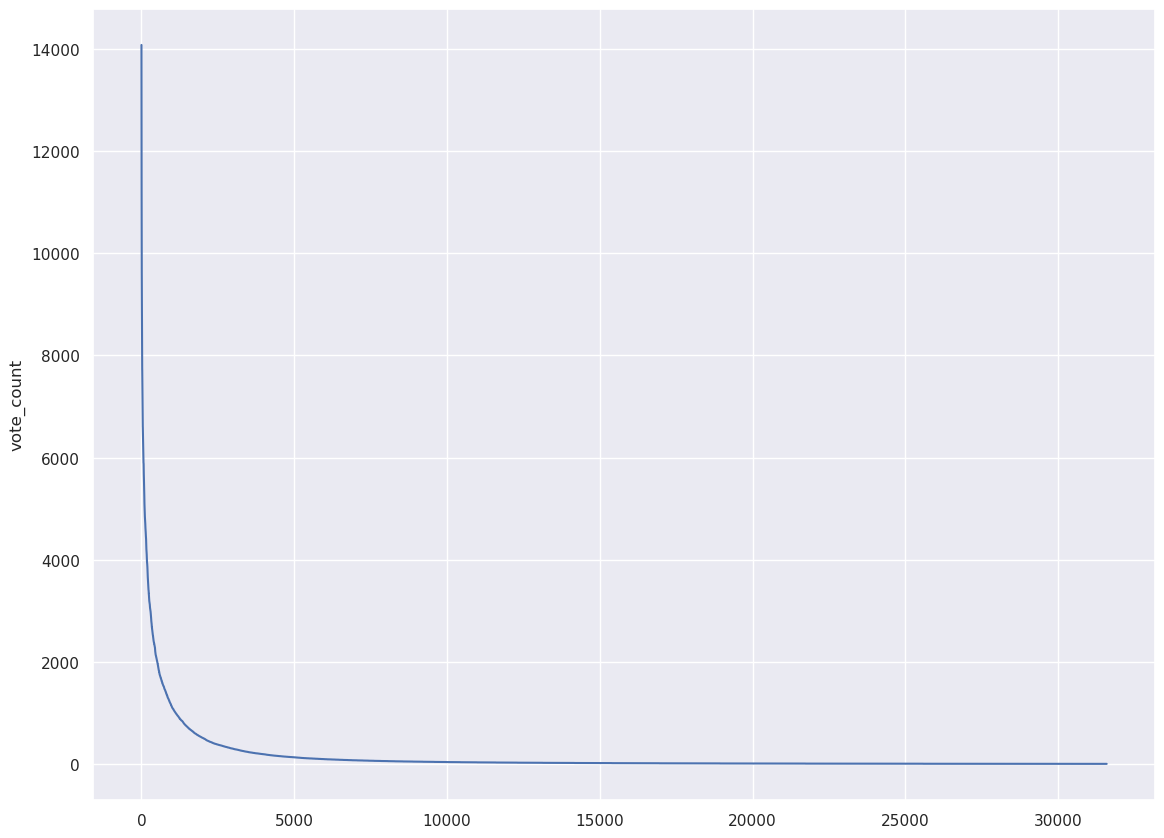

In [16]:
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.lineplot(data=smd.sort_values(by=['vote_count'], ascending=False).reset_index()['vote_count'], );

## Rating preprocecing

In [223]:
rating = pd.read_csv("datasets/normal_ratings.csv")
rating.timestamp = pd.to_datetime(rating.timestamp)

In [224]:
total_users = rating['userId'].nunique()

# Calculate item popularity
item_popularity = rating.groupby('movieId')['userId'].nunique().div(total_users).to_dict()

print("Item Popularity:")
print(f'{smd[smd['movieId']==1]['title'].values[0]}: {item_popularity[1]}')
print(f'{smd[smd['movieId']==2]['title'].values[0]}: {item_popularity[2]}')
print(f'{smd[smd['movieId']==120625]['title'].values[0]}: {item_popularity[120625]}')

Item Popularity:
Toy Story: 0.3525818101279062
Jumanji: 0.14905777619185312
The Fool: 0.001248915658203161


In [225]:
# Calculate item frequency
item_freq = rating.groupby('movieId').size().to_dict()

print("Item Popularity:")
print(f'{smd[smd['movieId']==1]['title'].values[0]}: {item_freq[1]}')
print(f'{smd[smd['movieId']==2]['title'].values[0]}: {item_freq[2]}')
print(f'{smd[smd['movieId']==120625]['title'].values[0]}: {item_freq[120625]}')

Item Popularity:
Toy Story: 57309
Jumanji: 24228
The Fool: 203


In [226]:
k = 5  # Desired number of ratings per user in the test set

test_ratings = []
for user_id, user_ratings in rating.groupby('userId'):
    # Sort user ratings by timestamp in descending order (most recent first)
    user_ratings = user_ratings.sort_values(by='timestamp', ascending=False)

    if len(user_ratings) >= k:
        test_ratings.append(user_ratings.head(k))  # Select the top 'k' (most recent)
    else:
        # Choose one of the options below:
        
        # Option 1: Exclude users with fewer than k ratings
        pass 
        
        # Option 2: Include all ratings for users with fewer than k ratings
        # test_ratings.append(user_ratings)

test_ratings = pd.concat(test_ratings)
train_ratings = rating[~rating.index.isin(test_ratings.index)] 

/tmp/ipykernel_58836/2726092224.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  sns.lineplot(rating.groupby('timestamp')['userId'].count().resample('M').sum());


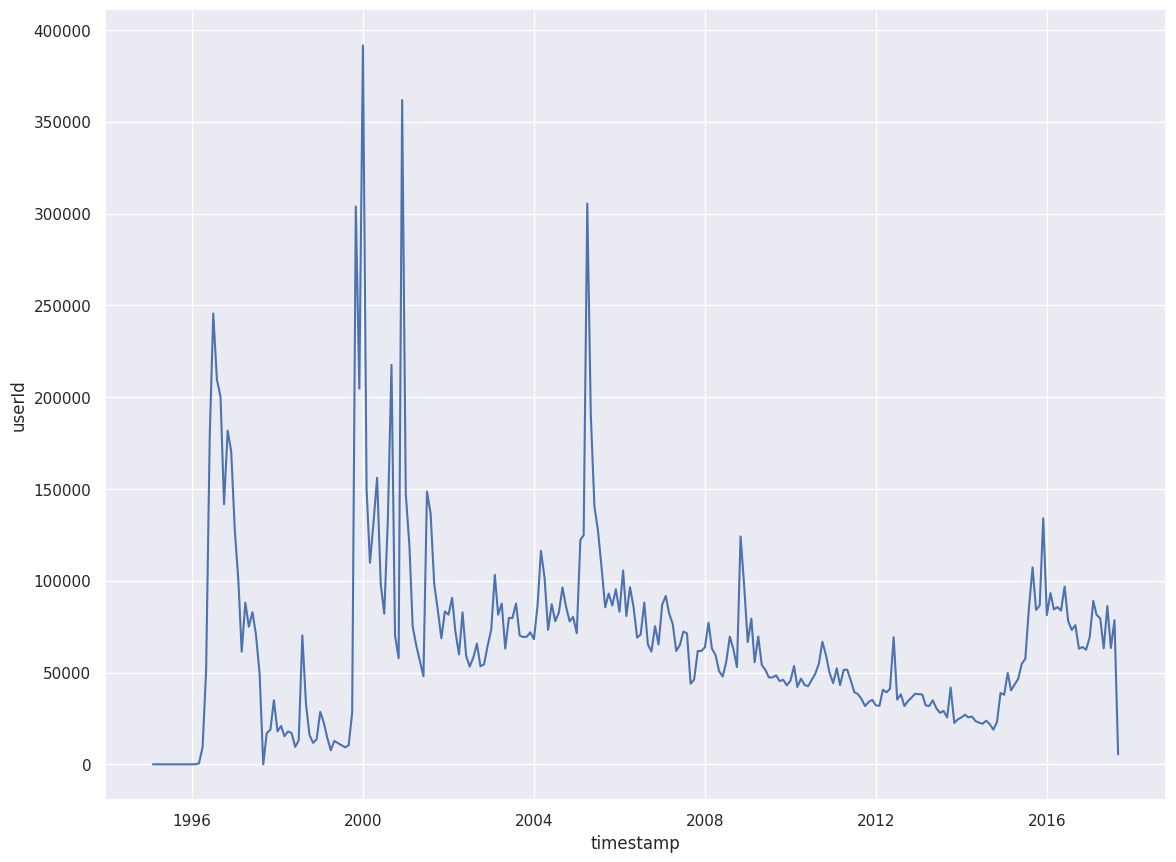

In [19]:
sns.lineplot(rating.groupby('timestamp')['userId'].count().resample('M').sum());

## Cosine model

In [494]:
vote_counts = smd[smd['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = smd[smd['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.median()
m = vote_counts.quantile(0.60)

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(model[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

def improved_recommendations(title):
    idx = indices[title]
    movie_indices, _ = model.similar_items(idx, N=20)
    movie_indices = np.delete(movie_indices, np.where(movie_indices == idx))
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.median()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

def improved_recommendations_by_idx(idx):
    movie_indices, scores = model.similar_items(idx, N=20)
    movie_indices = np.delete(movie_indices, np.where(movie_indices == idx))
    
    movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.median()
    m = vote_counts.quantile(0.60)
    qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [495]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 1), stop_words='english')
#count = TfidfVectorizer(analyzer='word',ngram_range=(1, 1), stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

In [496]:
smd[smd.title.str.contains('Snatch',flags=2,na=False)][['title', 'overview', 'year', 'director', 'actors', 'vote_count', 'genres', 'vote_average']]

,title,overview,year,director,actors,vote_count,genres,vote_average
380,Body Snatchers,When Environmental Protection Agency inspector...,1993,"[abelferrara, abelferrara, abelferrara]","[gabrielleanwar, terrykinney, billywirth, chri...",102.0,"[Science Fiction, Horror, Thriller]",5.8
1119,The Body Snatcher,"Edinburgh, 1831. Among those who undertake the...",1945,"[robertwise, robertwise, robertwise]","[boriskarloff, belalugosi, henrydaniell, edith...",47.0,"[Thriller, Horror]",6.8
2241,Invasion of the Body Snatchers,A small-town doctor learns that the population...,1956,"[donsiegel, donsiegel, donsiegel]","[kevinmccarthy, danawynter, kingdonovan, carol...",277.0,"[Science Fiction, Horror]",7.3
3454,Snatch,The second film from British director Guy Ritc...,2000,"[guyritchie, guyritchie, guyritchie]","[beniciodeltoro, dennisfarina, vinniejones, br...",2953.0,"[Thriller, Crime]",7.7
6164,Invasion of the Body Snatchers,The first remake of the paranoid infiltration ...,1978,"[philipkaufman, philipkaufman, philipkaufman]","[donaldsutherland, brookeadams, leonardnimoy, ...",231.0,"[Science Fiction, Horror, Thriller, Mystery]",7.1
15988,"Goke, Body Snatcher from Hell",The survivors of a plane crash in a remote are...,1968,"[hajimesato, hajimesato, hajimesato]","[teruoyoshida, tomomisatô, eizokitamura, hideo...",8.0,"[Science Fiction, Horror, Thriller]",7.2
16814,The Candy Snatchers,An abused autistic boy is the sole witness to ...,1973,"[guerdontrueblood, guerdontrueblood, guerdontr...","[tiffanybolling, benpiazza, susansennett, brad...",8.0,"[Drama, Thriller]",6.8
19836,The Bone Snatcher,"After miners disappear in the Namib Desert, so...",2003,"[jasonwulfsohn, jasonwulfsohn, jasonwulfsohn]","[scottbairstow, rachelshelley, warrickgrier, p...",12.0,"[Science Fiction, Horror]",4.5
30208,Snatched,"When her boyfriend dumps Emily, a spontaneous ...",2017,"[jonathanlevine, jonathanlevine, jonathanlevine]","[amyschumer, goldiehawn, tombateman, christoph...",207.0,"[Comedy, Action]",5.2


In [518]:
#model = BM25Recommender(K=30, K1=0.1, B=0.2) #good for raw model
model = BM25Recommender(K=50, K1=1.5, B=0.8)
#model = BM25Recommender(K=50, K1=1.5, B=0.8) # only with 1 director
model.fit(count_matrix.T)

/home/d_mamul/miniconda3/envs/myenv/lib/python3.12/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.006488800048828125 seconds
  warnings.warn(


  0%|          | 0/31588 [00:00<?, ?it/s]

In [506]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
idx, _ = model.similar_items([indices[temp[6]]], N=10)
smd.iloc[idx.flatten()][['title', 'vote_count', 'vote_average', 'year']]

,title,vote_count,vote_average,year
11006,In Bruges,1414.0,7.4,2008
16028,Seven Psychopaths,1224.0,6.7,2012
11526,Six Shooter,42.0,7.5,2004
29981,Two Is a Family,765.0,7.6,2016
27034,Lovers of the Café Flore,8.0,6.3,2006
27662,The Ones Below,84.0,6.0,2015
27604,War and Peace,7.0,5.6,2007
13745,127 Hours,2668.0,7.0,2010
13520,The American,488.0,5.8,2010
28813,Clean Hands,11.0,5.2,2015


In [507]:
improved_recommendations('Snatch')

/tmp/ipykernel_2637342/1207531148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,title,vote_count,vote_average,year,wr
12692,Sherlock Holmes,5883,7,2009,6.995600
15227,Sherlock Holmes: A Game of Shadows,3971,7,2011,6.993495
23143,The Man from U.N.C.L.E.,2306,7,2015,6.988851
2139,"Lock, Stock and Two Smoking Barrels",1671,7,1998,6.984679
15958,Taken 2,2783,6,2012,6.000000
11582,RockNRolla,851,6,2008,6.000000
9370,Revolver,415,6,2005,6.000000
29604,King Arthur: Legend of the Sword,1506,6,2017,6.000000


In [172]:
improved_recommendations('The Rock')

/tmp/ipykernel_2637342/1207531148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,title,vote_count,vote_average,year,wr
3720,Pearl Harbor,1833,6,2001,6.000000
10926,National Treasure: Book of Secrets,1782,6,2007,6.000000
9120,The Island,1813,6,2005,6.000000
12151,Transformers: Revenge of the Fallen,3192,6,2009,6.000000
10617,Transformers,4113,6,2007,6.000000
14599,Transformers: Dark of the Moon,3351,6,2011,6.000000
1556,Armageddon,2540,6,1998,6.000000
18202,Transformers: Age of Extinction,3136,5,2014,5.008223


In [173]:
improved_recommendations('Gladiator')

/tmp/ipykernel_2637342/1207531148.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
/tmp/ipykernel_2637342/1207531148.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

,title,vote_count,vote_average,year,wr
10835,American Gangster,1527,7,2007,6.983258
13153,Robin Hood,1434,6,2010,6.000000
11546,Body of Lies,919,6,2008,6.000000
19198,The Water Diviner,439,6,2014,6.000000
8934,Kingdom of Heaven,1187,6,2005,6.000000
17826,3 Days to Kill,896,6,2014,6.000000
18980,Exodus: Gods and Kings,1957,5,2014,5.013111
30209,The Mummy,2122,5,2017,5.012104


In [2156]:
#improved_recommendations_by_idx([15469])
improved_recommendations('The Fool')

<ipython-input-2148-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2148-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2148-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
30405,The Earthquake,9,7,2016,6.257143
20206,The Major,24,6,2013,6.000000
30143,Demobbed,11,6,2000,6.000000
19279,Hard to Be a God,41,6,2013,6.000000
14168,Silent Souls,21,6,2010,6.000000
8260,Cremaster 2,9,5,1999,5.742857
23807,The PyraMMMid,12,5,2011,5.684211
19661,Forbidden Kingdom,71,4,2014,4.536082


In [2629]:
improved_recommendations('Face/Off')

<ipython-input-2260-06f5e6a0cc0f>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_count'] = qualified['vote_count'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualified['vote_average'] = qualified['vote_average'].astype('int')
<ipython-input-2260-06f5e6a0cc0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

,title,vote_count,vote_average,year,wr
8433,Oldboy,2000,8,2003,7.974334
873,Die Hard,4005,7,1988,6.993550
15947,End of Watch,1186,7,2012,6.978548
1287,Con Air,1289,6,1997,6.000000
142,Die Hard: With a Vengeance,2094,6,1995,6.000000
396,Demolition Man,1018,6,1993,6.000000
140,Desperado,898,6,1995,6.000000
5603,The Italian Job,1949,6,2003,6.000000


# Hybrid model

In [161]:
data = csr_matrix((rating.rating.values.astype('f8'),
                   (rating.userId.values,rating.movieId.values)
                  ))

In [162]:
_, S, V = svds(data, k=100, return_singular_vectors='vh')

In [166]:
def unit_vector_normalize(arr):
    norm = np.linalg.norm(arr)
    return arr / norm

def improved_recommendations_by_idx_v2(title):
    idx = indices[title]
    
    if type(idx) != list():
        idx = [idx]
        
    movie_indices_knn, knn_scores = model.similar_items(idx, N=30)
    knn_scores = unit_vector_normalize(knn_scores.flatten())[1:]
    movie_indices_knn = movie_indices_knn.flatten()[1:]
    
    colaborative_scores = (-V.T @ V[:, idx].sum(axis=1))
    movie_indices_colaborative  = np.argsort(colaborative_scores)[:30]
    movie_indices_colaborative = movie_indices_colaborative[1:]
    colaborative_scores = -unit_vector_normalize(colaborative_scores)[movie_indices_colaborative]
    # print(knn_scores)
    # print(colaborative_scores)
    
    df1 = pd.DataFrame({'idx': movie_indices_knn, 'model_score1': knn_scores})
    df2 = pd.DataFrame({'idx': movie_indices_colaborative, 'model_score2': colaborative_scores})
    df2['model_score2'] = df2.apply(lambda x: x['model_score2']/smd['popularity'].iloc[int(x['idx'])], axis=1)
    # df2['model_score2'] = df2.apply(lambda x:x['idx'], axis=1)
    
    # Merge the dataframes on the 'idx' column with a left join
    merged_df = pd.merge(df1, df2, on='idx', how='outer')
    #print(merged_df)
    # Fill missing values with zeros
    merged_df.fillna(0, inplace=True)

    # Define the weights
    weight1 = 0.5
    weight2 = 0.5
    
    # Calculate the result column based on the given formula
    merged_df['result'] = weight1 * merged_df['model_score1'] + weight2 * merged_df['model_score2']
    merged_df = merged_df.sort_values(by='result', ascending=False)
    
    movies = smd[['title', 'vote_count', 'vote_average', 'year']]
    return movies.loc[merged_df['idx'].values[:10]]

In [167]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
improved_recommendations_by_idx_v2(temp[5])

,title,vote_count,vote_average,year
2599,British Intelligence,5.0,5.8,1940
13153,Robin Hood,1434.0,6.2,2010
11546,Body of Lies,919.0,6.5,2008
10835,American Gangster,1527.0,7.4,2007
10145,A Good Year,360.0,6.5,2006
19198,The Water Diviner,439.0,6.8,2014
18980,Exodus: Gods and Kings,1957.0,5.6,2014
7379,1492: Conquest of Paradise,180.0,6.1,1992
30438,Stratton,26.0,4.8,2017
8934,Kingdom of Heaven,1187.0,6.6,2005


In [2747]:
smd[smd.title.str.contains('The Nanny Diaries',flags=2,na=False)]

,imdb_id,id,movieId,adult,title,belongs_to_collection,budget,homepage,original_language,original_title,...,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,genres,director,actors
10705,tt0489237,12435,54780,False,The Nanny Diaries,NaN,20000000,NaN,en,The Nanny Diaries,...,6.1,335.0,"[{'cast_id': 6, 'character': 'Annie Braddock',...","[{'credit_id': '52fe44e09251416c7504408d', 'de...","['nanny', 'snob', 'little boy', 'woman director']",11,12,"['Drama', 'Comedy', 'Romance']",Shari Springer Berman,"['Scarlett Johansson', 'Laura Linney', 'Nichol..."


# ALS

In [20]:
# np.save('v_mtrx', V)
# model.save('model_implicit')

## Surprise

In [111]:
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file('datasets/my_ratings.csv', reader=reader)

In [114]:
trainset, testset = train_test_split(data, test_size=0.25)

In [124]:
# We'll use the famous SVD algorithm.
algo = SVD(n_factors=1000, n_epochs=40, )

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8146


0.8145786688769685

In [134]:
user_id = 123  # Specify the user ID for which you want to get recommendations
n_rec = 10  # Number of recommendations to generate

# Get the list of all item IDs in the dataset
all_item_ids = trainset.all_items()

# Exclude items that the user has already rated
user_item_ids = trainset.ur[user_id]
items_to_exclude = [item_id for (item_id, _) in user_item_ids]

# Generate recommendations for the user
predictions = []
for item_id in all_item_ids:
    if item_id not in items_to_exclude:
        predicted_rating = algo.predict(user_id, item_id).est
        predictions.append((item_id, predicted_rating))

# Sort the predictions in descending order of ratings and get the top N recommendations
predictions.sort(key=lambda x: x[1], reverse=True)
top_n_recommendations = predictions[:n_rec]

# Print the recommended item IDs and their predicted ratings
for item_id, predicted_rating in top_n_recommendations:
    print(f"Item ID: {item_id}, Predicted Rating: {predicted_rating}")

Item ID: 0, Predicted Rating: 3.520466681569228
Item ID: 1, Predicted Rating: 3.520466681569228
Item ID: 2, Predicted Rating: 3.520466681569228
Item ID: 3, Predicted Rating: 3.520466681569228
Item ID: 4, Predicted Rating: 3.520466681569228
Item ID: 5, Predicted Rating: 3.520466681569228
Item ID: 6, Predicted Rating: 3.520466681569228
Item ID: 8, Predicted Rating: 3.520466681569228
Item ID: 11, Predicted Rating: 3.520466681569228
Item ID: 12, Predicted Rating: 3.520466681569228


In [164]:
os.environ["OPENBLAS_NUM_THREADS"] = "1"

als = AlternatingLeastSquares()

In [153]:
test_rt = rating[rating.timestamp > '2012']
train_rt = rating[rating.timestamp <= '2012']

In [ ]:
als.fit()

## Implicit

### Metrics

In [310]:
def average_precision(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mean_average_precision(actual, predicted, k=10):
    return np.mean([average_precision(a, p, k) for a, p in zip(actual, predicted)])

def recall_at_k(actual, predicted, k=10):
    if len(predicted) > k:
        predicted = predicted[:k]

    act_set = set(actual)
    pred_set = set(predicted)

    return len(act_set & pred_set) / float(len(act_set))

def mean_recall_at_k(actual, predicted, k=10):
    return np.mean([recall_at_k(a, p, k) for a, p in zip(actual, predicted)])

def recall_no_pop(actual, predicted, item_popularity, k=10, pop_threshold=0.5):
    # Determine the popular items
    popular_items = {item for item, pop in item_popularity.items() if pop >= pop_threshold}

    # Filter out popular items from actual and predicted
    actual_filtered = [a for a in actual if a not in popular_items]
    predicted_filtered = [p for p in predicted if p not in popular_items][:k]

    if not actual_filtered:
        return 0.0

    act_set = set(actual_filtered)
    pred_set = set(predicted_filtered)

    return len(act_set & pred_set) / float(len(act_set))


def mean_recall_no_pop(actual, predicted, item_popularity, k=10, pop_threshold=0.5):
    return np.mean([recall_no_pop(a, p, item_popularity, k, pop_threshold) for a, p in zip(actual, predicted)])

def serendipity(actual, predicted, item_popularity, k=10):
    popular_items = {item for item, pop in item_popularity.items() if pop >= 0.5}  # Define popularity threshold

    serendipitous_recommendations = 0
    total_recommendations = 0

    for a, p in zip(actual, predicted):
        if len(p) > k:
            p = p[:k]
        act_set = set(a)
        pred_set = set(p)

        for item in pred_set:
            if item in act_set and item not in popular_items:
                serendipitous_recommendations += 1
        total_recommendations += len(pred_set)

    return serendipitous_recommendations / total_recommendations

def miuf(recommended, item_freq, k=10):
    user_miuf_scores = []

    for user_rec in recommended:
        if len(user_rec) > k:
            user_rec = user_rec[:k]
        user_score = 0
        for item in user_rec:
            user_score += 1 / math.log(1 + item_freq.get(item, 1))
        user_miuf_scores.append(user_score)

    return np.mean(user_miuf_scores)

In [40]:
# Example data
actual = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]
predicted = [[10, 1, 2, 9], [5, 11, 4], [7, 8, 12, 13]]
item_popularity = {1: 0.7, 2: 0.6, 3: 0.1, 4: 0.5, 5: 0.4, 6: 0.3, 7: 0.2, 8: 0.1, 9: 0.05, 10: 0.01, 11: 0.02, 12: 0.03, 13: 0.05}
item_freq = {1: 15, 2: 14, 3: 5, 4: 12, 5: 11, 6: 8, 7: 7, 8: 6, 9: 5, 10: 4, 11: 3, 12: 2, 13: 1}

# Calculating metrics
map_score = mean_average_precision(actual, predicted, k=3)
recall_score = mean_recall_at_k(actual, predicted, k=3)
recall_no_pop_score = mean_recall_no_pop(actual, predicted, item_popularity, k=3)
serendipity_score = serendipity(actual, predicted, item_popularity, k=3)
miuf_score = miuf(predicted, item_freq, k=3)

print("MAP:", map_score)
print("Recall:", recall_score)
print("Recall_no_pop:", recall_no_pop_score)
print("Serendipity:", serendipity_score)
print("MIUF:", miuf_score)

MAP: 0.6296296296296297
Recall: 0.7222222222222222
Recall_no_pop: 0.5
Serendipity: 0.3333333333333333
MIUF: 1.5899874512959633


### Model

In [228]:
train_data = csr_matrix((train_ratings.rating.values.astype('f8'),
                   (train_ratings.userId.values,train_ratings.movieId.values)
                  ))
test_data = csr_matrix((test_ratings.rating.values.astype('f8'),
                   (test_ratings.userId.values,test_ratings.movieId.values)
                  ))

In [322]:
# Define the parameter grid
param_grid = {
    'factors': [50, 100, 200],  # Number of latent factors
    'regularization': [0.01, 0.1, 1.0],  # Regularization parameter
    'iterations': [20, 30, 50],  # Number of iterations
    'alpha': [0.1],  # Confidence parameter
    'random_state': [42]  # Random state for reproducibility
}

In [323]:
from itertools import product

param_combinations = list(product(*param_grid.values()))
param_combinations = [dict(zip(param_grid.keys(), values)) for values in param_combinations]
len(param_combinations)

27

In [324]:
# Transpose the user-item matrix to get items as rows and users as columns
item_user_matrix = train_data.T.tocsr()

# Extract actual ratings for each user from the test data
actual_ratings = [list(test_data[user_id].indices) for user_id in test_ratings.userId.unique()][:50000]

In [325]:
for comb in param_combinations:
    als = AlternatingLeastSquares(**comb)
    als.fit(train_data)
    
    # Here, we'll generate 10 recommendations for each user
    user_recommendations = [list(als.recommend(userid, train_data[userid], N=6)[0]) for userid in test_ratings.userId.unique()[:50000]]

    recall_score = mean_recall_at_k(actual_ratings, user_recommendations, k=5)
    serendipity_score = serendipity(actual_ratings, user_recommendations, item_popularity, k=5)

    print('___'*20)
    print(comb)
    print("Recall:", recall_score)
    print("Serendipity:", serendipity_score)

  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.01, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050428
Serendipity: 0.050276


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.01, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050336000000000006
Serendipity: 0.050156


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.01, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050252
Serendipity: 0.05008


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.1, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050455999999999994
Serendipity: 0.0503


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.1, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.05044
Serendipity: 0.050256


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 0.1, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050364
Serendipity: 0.050188


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 1.0, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050384000000000005
Serendipity: 0.050248


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 1.0, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050455999999999994
Serendipity: 0.050312


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 50, 'regularization': 1.0, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.050432
Serendipity: 0.050272


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.01, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.04886
Serendipity: 0.04886


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.01, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.048852
Serendipity: 0.048852


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.01, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.048763999999999995
Serendipity: 0.048764


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.1, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.048904
Serendipity: 0.048904


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.1, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.0489
Serendipity: 0.0489


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 0.1, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.048788000000000005
Serendipity: 0.048788


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 1.0, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.048695999999999996
Serendipity: 0.048696


  0%|          | 0/30 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 1.0, 'iterations': 30, 'alpha': 0.1, 'random_state': 42}
Recall: 0.04900000000000001
Serendipity: 0.049


  0%|          | 0/50 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 100, 'regularization': 1.0, 'iterations': 50, 'alpha': 0.1, 'random_state': 42}
Recall: 0.049068
Serendipity: 0.049068


  0%|          | 0/20 [00:00<?, ?it/s]

____________________________________________________________
{'factors': 200, 'regularization': 0.01, 'iterations': 20, 'alpha': 0.1, 'random_state': 42}
Recall: 0.042736
Serendipity: 0.042736


  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [354]:
als = AlternatingLeastSquares(**{'factors': 50, 'regularization': 1.0, 'iterations': 30, 'alpha': 0.1, 'random_state': 42})
als.fit(train_data)

  0%|          | 0/30 [00:00<?, ?it/s]

In [327]:
# Generate recommendations for all users in the test set

# Transpose the user-item matrix to get items as rows and users as columns
item_user_matrix = train_data.T.tocsr()

# Here, we'll generate 10 recommendations for each user
user_recommendations = [list(als.recommend(userid, train_data[userid], N=6)[0]) for userid in test_ratings.userId.unique()]

# Extract actual ratings for each user from the test data
actual_ratings = [list(test_data[user_id].indices) for user_id in test_ratings.userId.unique()]

In [328]:
# Calculate metrics
map_score = mean_average_precision(actual_ratings, user_recommendations, k=5)
recall_score = mean_recall_at_k(actual_ratings, user_recommendations, k=5)
recall_no_pop_scored = mean_recall_no_pop(actual_ratings, user_recommendations, item_popularity, k=5)
serendipity_score = serendipity(actual_ratings, user_recommendations, item_popularity, k=5)
miuf_score = miuf(user_recommendations, item_freq, k=5)

# Print or log the evaluation results
print("MAP:", map_score)
print("Recall:", recall_score)
print("Recall_no_pop:", recall_no_pop_score)
print("Serendipity:", serendipity_score)
print("MIUF:", miuf_score)

MAP: 0.028254152823920263
Recall: 0.05031130798572659
Recall_no_pop: 0.05132757064927609
Serendipity: 0.05016119109142365
MIUF: 0.48485743235391504


In [279]:
als.similar_items(1, N=10)

(array([   1, 3114,  588,  150,  780, 4886,  364, 6377,  480, 1270],
       dtype=int32),
 array([1.        , 0.6835447 , 0.56960785, 0.56461656, 0.55301136,
        0.5516176 , 0.5456884 , 0.53908485, 0.5386921 , 0.5352651 ],
       dtype=float32))

In [286]:
id_movId = smd['movieId'].to_dict()
id_movId = {v: k for k,v in id_movId.items()}

In [307]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
smd[smd['title']=='In Bruges']

,index,imdb_id,id,movieId,adult,title,belongs_to_collection,budget,homepage,original_language,...,vote_count,cast,crew,keywords,cast_size,crew_size,genres,director,actors,soup
11006,11006,tt0780536,8321,57669,False,In Bruges,NaN,15000000,http://www.filminfocus.com/film/in_bruges,en,...,1414.0,"[{'cast_id': 11, 'character': 'Ray', 'credit_i...","[{'credit_id': '52fe449ec3a36847f80a06b7', 'de...",[],24,25,"[Drama, Comedy, Crime]",[martinmcdonagh],"[colinfarrell, brendangleeson, ralphfiennes, c...",colinfarrell brendangleeson ralphfiennes cléme...


In [308]:
idx, _ = als.similar_items(57669, N=10)
idx = [id_movId[i] for i in idx]
smd.iloc[idx][['title', 'vote_count', 'vote_average', 'year']]

,title,vote_count,vote_average,year
11006,In Bruges,1414.0,7.4,2008
11468,Burn After Reading,1251.0,6.5,2008
10928,There Will Be Blood,1581.0,7.9,2007
10840,No Country for Old Men,3083.0,7.7,2007
10347,Hot Fuzz,2252.0,7.4,2007
9286,Kiss Kiss Bang Bang,900.0,7.2,2005
10745,Eastern Promises,867.0,7.2,2007
11701,The Wrestler,1031.0,7.3,2008
14678,Drive,3832.0,7.4,2011
13903,True Grit,1701.0,7.2,2010


### Hybrid model

In [508]:
data = csr_matrix((rating.rating.values.astype('f8'),
                   (rating.userId.values,rating.movieId.values)))
als = AlternatingLeastSquares(**{'factors': 50, 'regularization': 1.0, 'iterations': 30, 'alpha': 0.1, 'random_state': 42})
# als = AlternatingLeastSquares()
als.fit(data)

  0%|          | 0/30 [00:00<?, ?it/s]

In [664]:
smd['popularity'].iloc[[1,2,3,4]]*5

1    85.077695
2    58.564500
3    19.297475
4    41.937595
Name: popularity, dtype: float64

In [709]:
def unit_vector_normalize(arr):
    norm = np.linalg.norm(arr)
    return arr / norm

def improved_recommendations_by_idx_v3(title):
    idx = indices[title]
    
    if type(idx) != list():
        idx = [idx]
        
    movie_indices_knn, knn_scores = model.similar_items(idx, N=30)
    knn_scores = unit_vector_normalize(knn_scores.flatten())[1:]
    movie_indices_knn = movie_indices_knn.flatten()[1:]
    
    movie_indices_als, als_scores = als.similar_items(idx, N=30)
    als_scores = unit_vector_normalize(als_scores.flatten())[1:]
    movie_indices_als = movie_indices_als.flatten()[1:]
    
    df1 = pd.DataFrame({'idx': movie_indices_knn, 'model_score1': knn_scores})
    df2 = pd.DataFrame({'idx': movie_indices_als, 'model_score2': als_scores})
    # df2['model_score2'] = df2.apply(lambda x: x['model_score2']/smd['popularity'].iloc[int(x['idx'])], axis=1)
    # df2['model_score2'] = df2.apply(lambda x:x['idx'], axis=1)
    
    # Merge the dataframes on the 'idx' column with a left join
    merged_df = pd.merge(df1, df2, on='idx', how='outer')
    #print(merged_df)
    # Fill missing values with zeros
    merged_df.fillna(0, inplace=True)

    # Define the weights
    weight1 = 0.6
    weight2 = 0.4

    # Calculate the combined score with popularity penalty
    merged_df['popularity'] = smd['popularity'].iloc[merged_df['idx'].values].values
    
    # Calculate the combined score
    merged_df['combined_score'] = weight1 * merged_df['model_score1'] + weight2 * merged_df['model_score2']
    
    # merged_df['combined_score'] = (weight1 * merged_df['model_score1']) / (merged_df['popularity'] + 1) + (weight2 * merged_df['model_score2'])
    
    movies = smd[['title', 'vote_count', 'vote_average', 'year']]

    # Apply XQuAD re-ranking
    def xquad_re_rank(df, num_recommendations=20, lambda_diversity=0.6):
        selected_indices = []
        aspect_coverage = np.zeros(len(df))
        
        for _ in range(num_recommendations):
            best_candidate = None
            best_score = -np.inf
            
            for idx in df.index:
                if idx in selected_indices:
                    continue
                
                candidate_score = df.loc[idx, 'model_score2']
                diversity_score = -lambda_diversity * aspect_coverage[idx]
                total_score = candidate_score + diversity_score
                
                if total_score > best_score:
                    best_score = total_score
                    best_candidate = idx
            
            if best_candidate is not None:
                selected_indices.append(best_candidate)
                aspect_coverage += df.loc[best_candidate, 'model_score2']
        
        return df.loc[selected_indices]

    # Re-rank the merged_df with XQuAD
    re_ranked_df = xquad_re_rank(merged_df, num_recommendations=20, lambda_diversity=0.5)
    re_ranked_df['combined_score'] = weight1 * merged_df['model_score1'] + weight2 * merged_df['model_score2']
    
    # flattened_list = [item for tup in list(zip(merged_df['idx'].values[:10], re_ranked_df['idx'].values[:10])) for item in tup]
    return movies.loc[re_ranked_df['idx'].values[:15]]
    # return movies.loc[flattened_list[:16]]

In [716]:
temp = ['One Flew Over the Cuckoo\'s Nest', 'The Rock', 'Inception', 'The Fool', 'The Green Elephant', 'Gladiator', 'In Bruges', 'Snatch']
improved_recommendations_by_idx_v3(temp[7])

,title,vote_count,vote_average,year
2139,"Lock, Stock and Two Smoking Barrels",1671.0,7.5,1998
1939,American History X,3120.0,8.2,1998
2793,The Boondock Saints,848.0,7.2,1999
3393,Requiem for a Dream,2525.0,7.9,2000
3674,Scarface,3017.0,8.0,1983
914,Reservoir Dogs,3821.0,8.1,1992
1427,The Big Lebowski,3001.0,7.8,1998
4241,Donnie Darko,3574.0,7.7,2001
8828,Sin City,2755.0,7.2,2005
3657,Blow,1352.0,7.4,2001


In [2747]:
## smd[smd.title.str.contains('The Nanny Diaries',flags=2,na=False)]

,imdb_id,id,movieId,adult,title,belongs_to_collection,budget,homepage,original_language,original_title,...,vote_average,vote_count,cast,crew,keywords,cast_size,crew_size,genres,director,actors
10705,tt0489237,12435,54780,False,The Nanny Diaries,NaN,20000000,NaN,en,The Nanny Diaries,...,6.1,335.0,"[{'cast_id': 6, 'character': 'Annie Braddock',...","[{'credit_id': '52fe44e09251416c7504408d', 'de...","['nanny', 'snob', 'little boy', 'woman director']",11,12,"['Drama', 'Comedy', 'Romance']",Shari Springer Berman,"['Scarlett Johansson', 'Laura Linney', 'Nichol..."
